In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("diabetes-dataset.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               2000 non-null   int64  
 1   Glucose                   2000 non-null   int64  
 2   BloodPressure             2000 non-null   int64  
 3   SkinThickness             2000 non-null   int64  
 4   Insulin                   2000 non-null   int64  
 5   BMI                       2000 non-null   float64
 6   DiabetesPedigreeFunction  2000 non-null   float64
 7   Age                       2000 non-null   int64  
 8   Outcome                   2000 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 140.8 KB


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

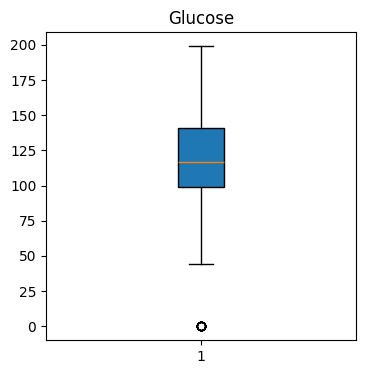

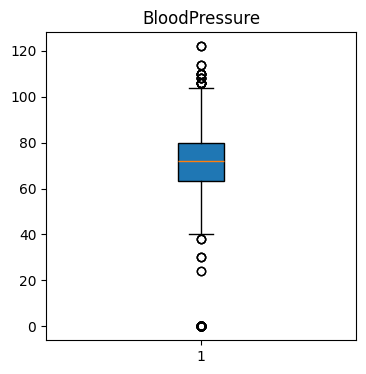

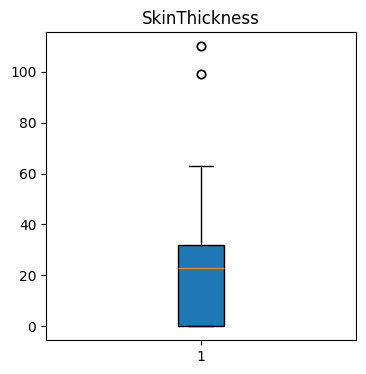

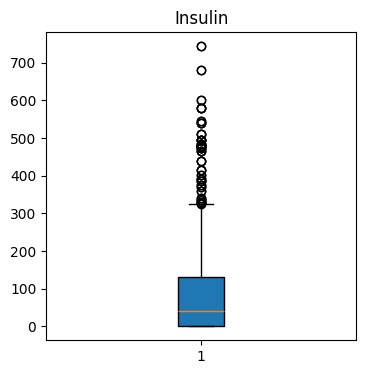

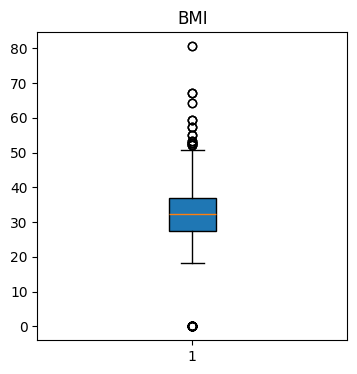

In [23]:
for name,column in df.iloc[:,1:6].items():
    plt.figure(figsize=(4,4))
    plt.boxplot(column,patch_artist=True)
    plt.title(name)
    plt.show()



In [ ]:
Улучшим наглядность:

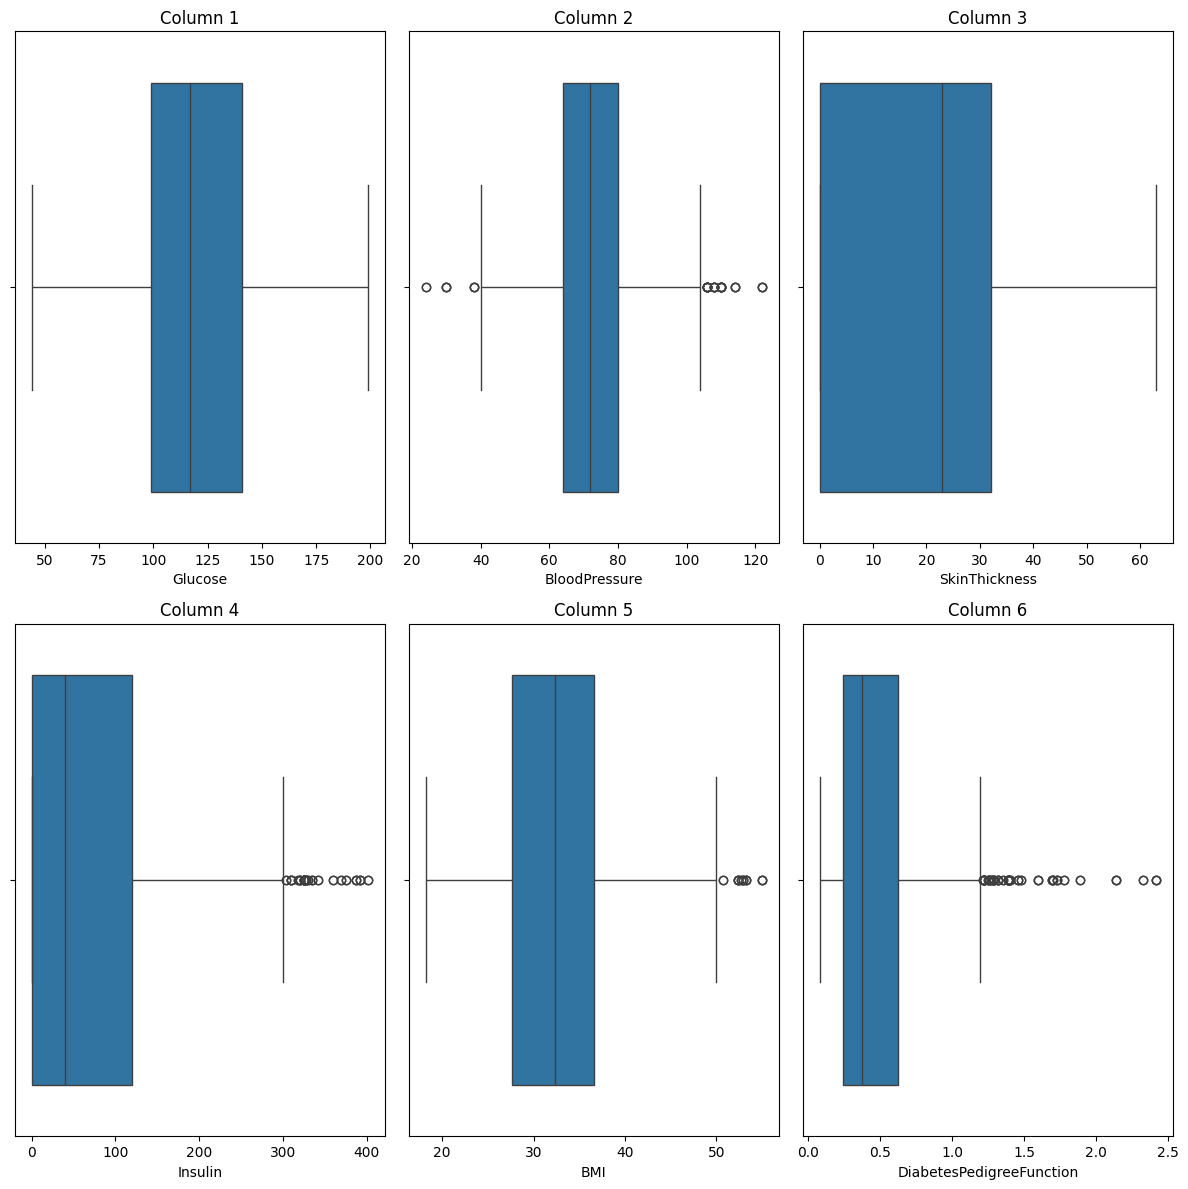

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))
axes = axes.flatten()
columns = [1,2,3,4,5,6]

for i, column in enumerate(columns):
    sns.boxplot(x=df.iloc[:, column], ax=axes[i])
    axes[i].set_title(f"Column {column}")

plt.tight_layout()
plt.show()

Видим, что выбросы есть! Минимизируем


In [29]:
from scipy import stats

threshold = 2# 3 как-то слабенько - 2 заметно!

for name,column in df.iloc[:,1:6].items():
    z_scores = stats.zscore(column)
    median_value = column.median()
    df.loc[abs(z_scores) > threshold, name] = median_value

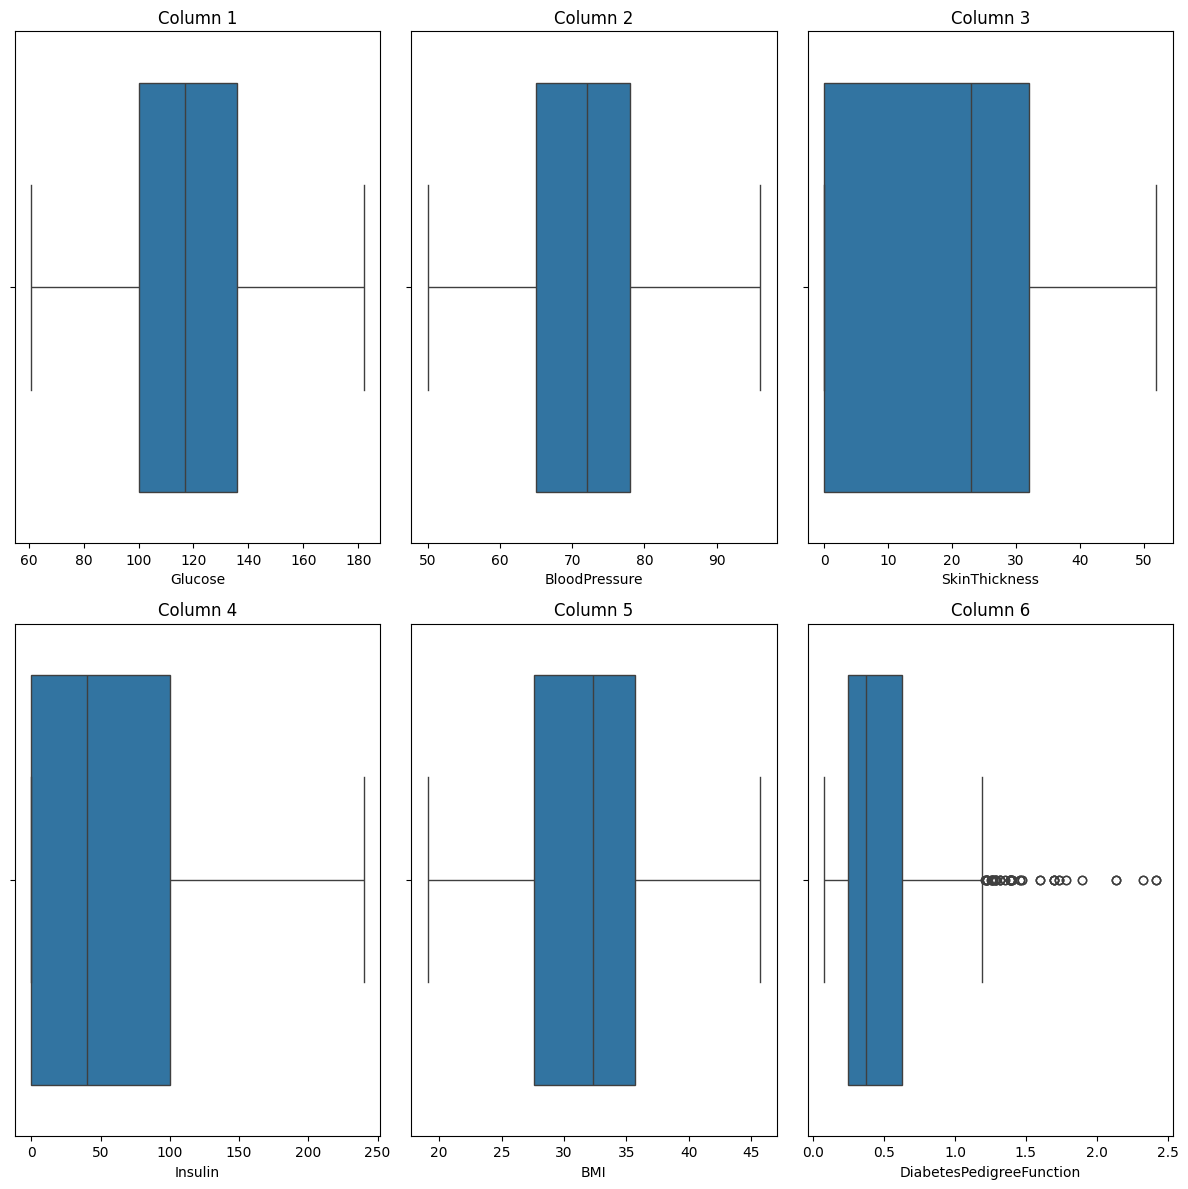

In [30]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))  # Матрица 3x3 для 9 графиков
axes = axes.flatten()
columns = [1,2,3,4,5,6]

for i, column in enumerate(columns):
    sns.boxplot(x=df.iloc[:, column], ax=axes[i])
    axes[i].set_title(f"Column {column}")

plt.tight_layout()
plt.show()

Посмотрим как факторы влияют на отсутствие или присутствие диабета

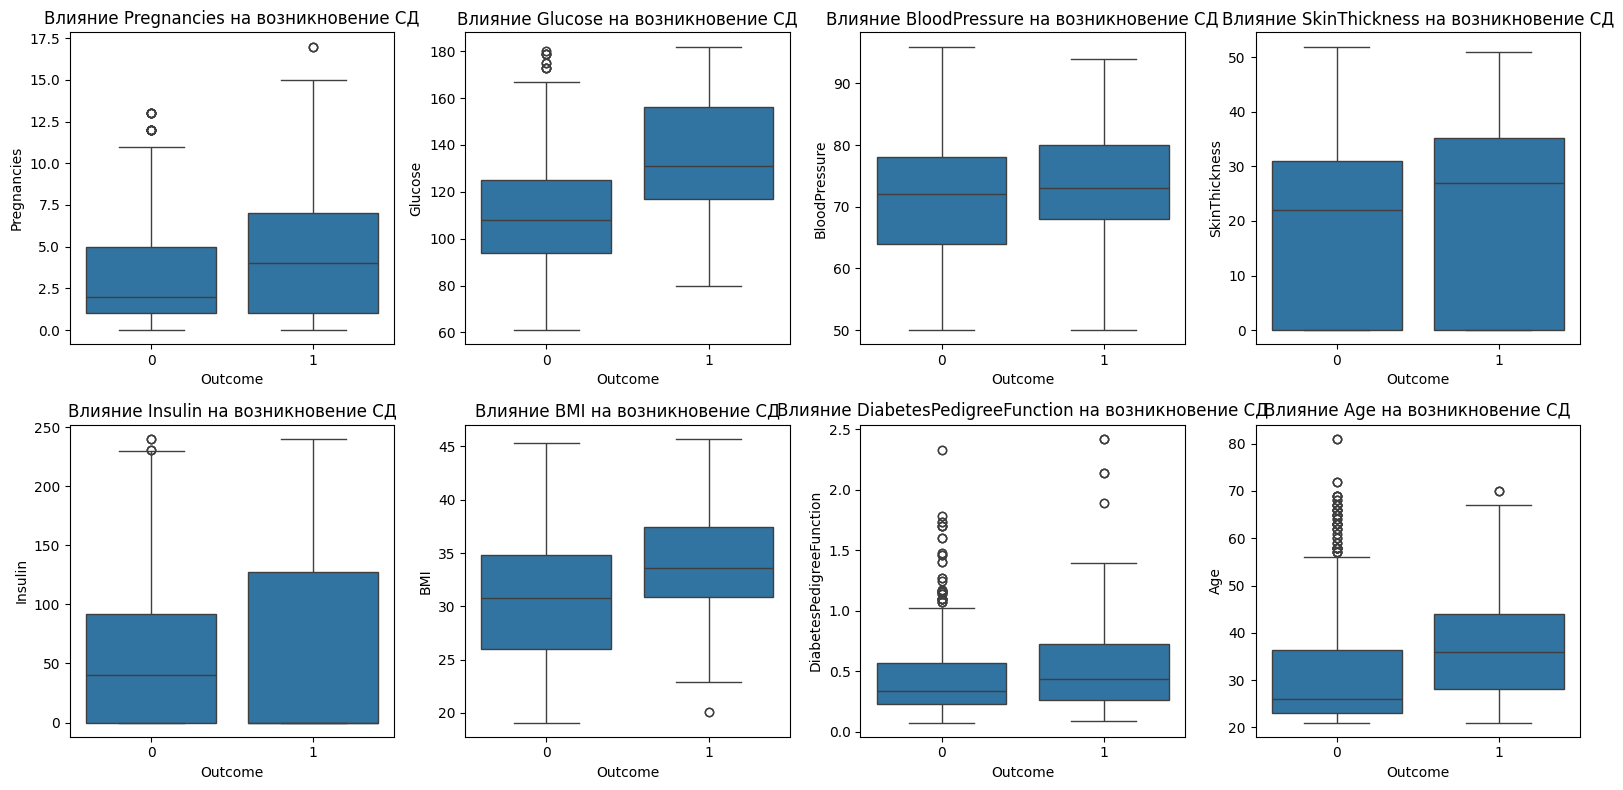

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()
columns = [0, 1, 2, 3, 4, 5, 6, 7]

for i, column in enumerate(columns):
    sns.boxplot(x=df['Outcome'], y=df.iloc[:, column], ax=axes[i])
    axes[i].set_title(f"Влияние {df.columns[column]} на возникновение СД")

plt.tight_layout()
plt.show()


По этим графикам явно видно что в случае диабета - 1 все показатели были выше! Ради интереса посмотрим являются ли эти отклонения стат. значимыми?

In [42]:
from scipy import stats

for name,column in df.iloc[:,:8].items():
    # Разделяем данные на группы
    group_0 = df[df['Outcome'] == 0][name]
    group_1 = df[df['Outcome'] == 1][name]
    
    # Проверка нормальности
    _, p_val_0 = stats.shapiro(group_0)
    _, p_val_1 = stats.shapiro(group_1)

    print(name)
    
    if p_val_0 > 0.05 and p_val_1 > 0.05:
        print("Данные нормально распределены, используем t-тест")
        stat, p_value = stats.ttest_ind(group_0, group_1, equal_var=False)
    else:
        print("Данные не нормально распределены, используем тест Манна-Уитни")
        stat, p_value = stats.mannwhitneyu(group_0, group_1)
    
    # Вывод результата теста
    if p_value < 0.05:
        print(f"Разница статистически значима (p = {p_value:.4f})")
    else:
        print(f"Нет статистически значимой разницы (p = {p_value:.4f})")


Pregnancies
Данные не нормально распределены, используем тест Манна-Уитни
Разница статистически значима (p = 0.0000)
Glucose
Данные не нормально распределены, используем тест Манна-Уитни
Разница статистически значима (p = 0.0000)
BloodPressure
Данные не нормально распределены, используем тест Манна-Уитни
Разница статистически значима (p = 0.0000)
SkinThickness
Данные не нормально распределены, используем тест Манна-Уитни
Разница статистически значима (p = 0.0001)
Insulin
Данные не нормально распределены, используем тест Манна-Уитни
Нет статистически значимой разницы (p = 0.7820)
BMI
Данные не нормально распределены, используем тест Манна-Уитни
Разница статистически значима (p = 0.0000)
DiabetesPedigreeFunction
Данные не нормально распределены, используем тест Манна-Уитни
Разница статистически значима (p = 0.0000)
Age
Данные не нормально распределены, используем тест Манна-Уитни
Разница статистически значима (p = 0.0000)


Разница почти везде значима, только инсулин пасет задних! Разделим данные

In [41]:
import math
n1=math.floor(0.2*len(df))
test_part=df.iloc[:n1,:].copy()
study_part=df.iloc[n1:,:].copy()

Создадим и обучим модель логистической регрессии

In [43]:
from sklearn.linear_model import LogisticRegression

# Создание модели
model = LogisticRegression()

X_study = study_part[['Glucose', 'Age']]
y_study = study_part['Outcome']

# Обучение модели
model.fit(X_study, y_study)

LogisticRegression()

In [46]:
X_test = test_part[['Glucose', 'Age']]

test_part['y_pred_prob'] = model.predict_proba(X_test)[:, 1]   # Вероятности классов

# Предсказание классов
test_part['y_pred'] = model.predict(X_test)

test_part.sample(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,y_pred_prob,y_pred
348,3,99,62,19,74,21.8,0.279,26,0,0.141043,0
385,1,119,54,13,50,22.3,0.205,24,0,0.250566,0
36,11,138,76,0,0,33.2,0.420,35,0,0.491820,0
237,0,179,90,27,0,44.1,0.686,23,1,0.766335,1
289,5,108,72,43,75,36.1,0.263,33,0,0.222794,0
246,10,122,68,0,0,31.2,0.258,41,0,0.384746,0
9,2,89,90,30,0,33.5,0.292,42,0,0.152935,0
365,5,99,54,28,83,34.0,0.499,30,0,0.156231,0
343,5,122,86,0,0,34.7,0.290,33,0,0.329671,0
190,3,111,62,0,0,22.6,0.142,21,0,0.183303,0


In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Точность
accuracy = accuracy_score(test_part['Outcome'], test_part['y_pred'])
print("Accuracy:", accuracy)

# Матрица ошибок
conf_matrix = confusion_matrix(test_part['Outcome'], test_part['y_pred'])
print("Confusion Matrix:\n", conf_matrix)

# Отчёт классификации
print("Classification Report:\n", classification_report(test_part['Outcome'], test_part['y_pred']))

Accuracy: 0.6975
Confusion Matrix:
 [[221  37]
 [ 84  58]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.86      0.79       258
           1       0.61      0.41      0.49       142

    accuracy                           0.70       400
   macro avg       0.67      0.63      0.64       400
weighted avg       0.68      0.70      0.68       400



In [83]:
from sklearn.preprocessing import StandardScaler

model = LogisticRegression()

X_study = study_part.iloc[:,:8]
X_test = test_part.iloc[:,:8]
y_study = study_part['Outcome']

scaler = StandardScaler()
# # Масштабируем данные
# X_study_scaled = scaler.fit_transform(X_study)

# Нормализация данных
X_study = scaler.fit_transform(X_study)
X_test = scaler.transform(X_test)

# model = LogisticRegression(max_iter=200)
model.fit(X_study, y_study)


LogisticRegression()

In [84]:
test_part['y_pred_prob'] = model.predict_proba(X_test)[:, 1]   # Вероятности классов

# Предсказание классов
test_part['y_pred'] = model.predict(X_test)

test_part.sample(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,y_pred_prob,y_pred
252,2,90,80,14,55,24.4,0.249,24,0,0.033761,0
357,13,129,72,30,0,39.9,0.569,44,1,0.845565,1
21,7,94,64,25,79,33.3,0.738,41,0,0.297175,0
86,13,106,72,23,0,36.6,0.178,45,0,0.551316,1
391,5,166,76,0,0,45.7,0.340,27,1,0.904069,1
150,1,136,74,50,204,37.4,0.399,24,0,0.391352,0
45,0,180,66,39,0,42.0,1.893,25,1,0.955344,1
377,1,87,60,37,75,37.2,0.509,22,0,0.115337,0
32,3,99,54,19,86,25.6,0.154,24,0,0.066451,0
287,1,119,86,39,220,45.6,0.808,29,1,0.524495,1


In [85]:
# Точность
accuracy = accuracy_score(test_part['Outcome'], test_part['y_pred'])
print("Accuracy:", accuracy)

# Матрица ошибок
conf_matrix = confusion_matrix(test_part['Outcome'], test_part['y_pred'])
print("Confusion Matrix:\n", conf_matrix)

# Отчёт классификации
print("Classification Report:\n", classification_report(test_part['Outcome'], test_part['y_pred']))

Accuracy: 0.725
Confusion Matrix:
 [[219  39]
 [ 71  71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       258
           1       0.65      0.50      0.56       142

    accuracy                           0.72       400
   macro avg       0.70      0.67      0.68       400
weighted avg       0.72      0.72      0.72       400



In [ ]:
С диабетом распознает очень плохо - 50/50 - так и я могу! Плоховато!

In [86]:
model = LogisticRegression()

X_study = study_part.iloc[:, 0:4].join(df.iloc[:, 5:8])
X_test = test_part.iloc[:, 0:4].join(df.iloc[:, 5:8])
y_study = study_part['Outcome']

scaler = StandardScaler()
# # Масштабируем данные
# X_study_scaled = scaler.fit_transform(X_study)

# Нормализация данных
X_study = scaler.fit_transform(X_study)
X_test = scaler.transform(X_test)

# model = LogisticRegression(max_iter=200)
model.fit(X_study, y_study)

LogisticRegression()

In [87]:
test_part['y_pred_prob'] = model.predict_proba(X_test)[:, 1]   # Вероятности классов

# Предсказание классов
test_part['y_pred'] = model.predict(X_test)

test_part.sample(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,y_pred_prob,y_pred
345,8,126,88,36,108,38.5,0.349,49,0,0.633324,1
252,2,90,80,14,55,24.4,0.249,24,0,0.034013,0
84,5,137,72,0,0,32.3,0.227,37,1,0.485695,0
123,5,132,80,0,0,26.8,0.186,69,0,0.428453,0
176,6,85,78,0,0,31.2,0.382,42,0,0.137999,0
327,10,179,70,0,0,35.1,0.200,37,0,0.918009,1
58,0,146,82,0,0,40.5,1.781,44,0,0.866085,1
229,0,117,80,31,53,45.2,0.089,24,0,0.327594,0
188,8,109,76,39,114,27.9,0.640,31,1,0.241270,0
244,2,146,76,35,194,38.2,0.329,29,0,0.561662,1


In [88]:
# Точность
accuracy = accuracy_score(test_part['Outcome'], test_part['y_pred'])
print("Accuracy:", accuracy)

# Матрица ошибок
conf_matrix = confusion_matrix(test_part['Outcome'], test_part['y_pred'])
print("Confusion Matrix:\n", conf_matrix)

# Отчёт классификации
print("Classification Report:\n", classification_report(test_part['Outcome'], test_part['y_pred']))

Accuracy: 0.73
Confusion Matrix:
 [[221  37]
 [ 71  71]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.80       258
           1       0.66      0.50      0.57       142

    accuracy                           0.73       400
   macro avg       0.71      0.68      0.69       400
weighted avg       0.72      0.73      0.72       400



В попытке выше я исключил столбец 'Insulin', изменения в котором не были статистически значимыми. Видим покращення на 0.005. В агонии отчаиния попытаемся разделить данные более правильно - не по индексам а случайно!

In [78]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 0:4].join(df.iloc[:, 5:8])
y = df['Outcome']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
# Создание модели
model = LogisticRegression()

# Обучение модели
model.fit(X_train, y_train)

LogisticRegression()

In [81]:
# Предсказание вероятностей
y_pred_prob = model.predict_proba(X_test)  # Вероятности классов

# Предсказание классов
y_pred = model.predict(X_test)

In [82]:
# Точность
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Отчёт классификации
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.75
Confusion Matrix:
 [[224  29]
 [ 71  76]]
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       253
           1       0.72      0.52      0.60       147

    accuracy                           0.75       400
   macro avg       0.74      0.70      0.71       400
weighted avg       0.75      0.75      0.74       400



In [ ]:
Только 0.75!

Попробуем применить SVM для классификации:

In [103]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X = df.iloc[:, 0:4].join(df.iloc[:, 5:8])
y = df['Outcome']
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение SVM с RBF ядром
model = SVC(kernel='rbf', C=1.0, gamma=0.5, probability=True)  # Включаем вероятность, если нужно
model.fit(X_train, y_train)

# Преобразование X_test в DataFrame (если нужно сохранить предсказания)
# X_test_df = X_test.copy()  # Копируем тестовые данные

# Предсказание
y_pred = model.predict(X_test)

# Оценка
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

res = pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred})
# Просмотр случайных 20 строк
res.sample(20)

Accuracy: 0.97


,y_test,y_pred
260,1,1
31,0,0
16,1,1
214,1,1
45,0,0
174,0,0
369,1,1
231,1,0
179,1,1
291,0,0


Много лучше!!! Угадываем в 97% случаев